# Model Inspection and Debugging

Building on top of previous lesson, learn how to inspect and debug models during training 

course: https://learn.deeplearning.ai/courses/pytorch-fundamentals/

lab follow-along (Module 4: Debugging, Inspection, Modularization): https://learn.deeplearning.ai/specializations/pytorch-for-deep-learning-professional-certificate/lesson/uzzlvtb/model-debugging%2C-inspection%2C-and-modularization 

note: basic debugging notes in previous exercise notebook ```pytorch-fundamentals-6-building-models.ipynb```

Steps
1. create basic model of a neural network with explicit layers
- train basic model on data
- troubleshoot basic model with debug statements, especially understanding layer shapes and model architecture and forward pass flow

2. refactor basic model into advanced model into sequential blocks after we get the model
- train advanced model on data
- troubleshoot advanced model with debug statements as well (checking for layer statistics, stability of activation layers, etc.)

In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import SqueezeNet

import numpy as np
import matplotlib.pyplot as pyplot

In [ ]:
# Utility functions
# from course lab's helper_utils

import os

import matplotlib as mpl
from torchvision import datasets


def apply_dlai_style():
    # Global plot style
    PLOT_STYLE = {
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "font.family": "sans",  # "sans-serif",
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "lines.linewidth": 3,
        "lines.markersize": 6,
    }

    # mpl.rcParams.update(PLOT_STYLE)

    # Custom colors (reusable)
    color_map = {
        "pink": "#F65B66",
        "blue": "#1C74EB",
        "yellow": "#FAB901",
        "red": "#DD3C66",
        "purple": "#A12F9D",
        "cyan": "#237B94",
    }
    return color_map, PLOT_STYLE


color_map, PLOT_STYLE = apply_dlai_style()
mpl.rcParams.update(PLOT_STYLE)


def get_dataset():
    
    path_dataset = "./data/FASHIONMNIST"

    # If the dataset path does not exist, create it
    if not os.path.exists(path_dataset):
        os.makedirs(path_dataset)

        # Download the Fashion MNIST validation dataset (from pyTorch)
        datasets.FashionMNIST(path_dataset, train=False, download=True)

    else:
        print("Dataset already exists.")
    # if the dataset is not dowloaded, download fashion_mnist

    # Load the Fashion MNIST validation dataset (from pyTorch)
    dataset = datasets.FashionMNIST(path_dataset, train=False, download=False)

    return dataset


def plot_counting(counting_params):
    import matplotlib.pyplot as plt

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.bar(counting_params.keys(), counting_params.values())
    plt.xlabel("Layer Name")
    plt.ylabel("Number of Parameters")
    plt.title("Number of Parameters in Each Terminal Layer")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [3]:
# Data Load

dataset = get_dataset() # Fashion MNIST
print(dataset)

Dataset already exists.
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FASHIONMNIST
    Split: Test


In [4]:
# Data: Transforms

# basic pre-processing transformation
transform_fns = transforms.ToTensor()
dataset.transform = transform_fns

In [5]:
# Data: Load data with preprocessing transformations

batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)   # basic dataset, no splits or shuffling even though should do so for training set

img_batch, label_batch = next(iter(dataloader))
print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28] - color channel grayscale, image size 28x28


Batch shape: torch.Size([64, 1, 28, 28])


In [6]:
# Model

# Define basic model
# explicit layers, not yet grouped in blocks with nn.sequential

class SimpleCNN(nn.Module):

    def __init__(self):

        super().__init__()

        # data sample image is size 28x28

        # conv block 1
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3,
            padding=1
        )
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # flatten
        # TODO: simulate error to debug by not including this layer        

        # fully connected block
        self.fc1 = nn.Linear(
            32 * 14 * 14,   # input from previous output * image size 14x14, which is halved from 28x28 after pooling in previous block 
            128 # out_channel
        )
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(
            128,
            10  # output classes
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x)

        return x

In [7]:
# Model

# instantiate simple model
simple_cnn = SimpleCNN()

# error: will yield error, which we will debug
try:
    output = simple_cnn(img_batch)
except Exception as e:
    print(f"Error during forward pass: {e}")

Error during forward pass: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


In [8]:
# Model: Debug

# extend model class to create a version for debugging

class SimpleCNNDebug(SimpleCNN):

    """ 
    course notes:

    You will define a new class that inherits from the original model and overrides the forward method to include print statements that display the shape of the tensor after each layer. A first try might be to explicitly separate the layers in the forward method and, for each layer:

    print the shape of the tensor before the layer (input shape),
    print the shape of some parameters of the layer (e.g., weights and biases)
    print the activation shape of the tensor after running through the layer (output shape), which will be the input for the next layer.
    
    """

    def __init__(self):
        
        super().__init__()

        # extension inherits layers from parent class, no need to redefine the model architecture here

    
    def forward(self, x):
        print(f"Input shape: {x.shape}")

        print(
            "(Layer components) Conv layer parameters (weights, biases) shapes:",
            self.conv1.weight.shape,
            self.conv1.bias.shape
        )

        x = self.conv1(x)
        x = self.relu1(x)

        
        print("(Activation) Tensor shape after convolution and ReLU activation:", x.shape)
        
        x = self.pool1(x)

        print("(Activation) Tensor shape after pooling:", x.shape)
        
        print("---")

        # Note: Addresses shape mismatch error between conv block and fully connected block by flattening the layer

        x = torch.flatten(
            x, start_dim=1
        )  # Flatten all dimensions except batch
        
        print("(Activation) After flattening:", x.shape)
        
        print("---")

        print(
            "(Layer components) Linear layer fc1",
            self.fc1.weight.shape,
            self.fc1.bias.shape
        )

        x = self.fc1(x)
        x = self.relu_fc(x)

        print("(Activation) Tensor shape after fc1 and ReLU:", x.shape)
        
        print("---")
        
        print(
            "(Layer components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x)


        print("(Activation) After fc2 (output):", x.shape)

        print("---")
        
        return x



In [9]:
# Model Debug

# run debug model

simple_cnn_debug = SimpleCNNDebug()

try:
    output_debug = simple_cnn_debug(img_batch)  
except Exception as e:
    print(f"Error during forward pass in debug model: {e}")

Input shape: torch.Size([64, 1, 28, 28])
(Layer components) Conv layer parameters (weights, biases) shapes: torch.Size([32, 1, 3, 3]) torch.Size([32])
(Activation) Tensor shape after convolution and ReLU activation: torch.Size([64, 32, 28, 28])
(Activation) Tensor shape after pooling: torch.Size([64, 32, 14, 14])
---
(Activation) After flattening: torch.Size([64, 6272])
---
(Layer components) Linear layer fc1 torch.Size([128, 6272]) torch.Size([128])
(Activation) Tensor shape after fc1 and ReLU: torch.Size([64, 128])
---
(Layer components) Linear layer fc2 parameters (weights, biases): torch.Size([10, 128]) torch.Size([10])
(Activation) After fc2 (output): torch.Size([64, 10])
---


In [10]:
# Model: Modularize

# create modularize version of model and debug 
class SimpleCNNModular(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        flattened_size = 32 * 14 * 14
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # 10 classes for Fashion MNIST
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_block(x)
        return x


simple_cnn_modular = SimpleCNNModular()
output = simple_cnn_modular(img_batch)

print("Output shape from modularized sequential model:", output.shape)


Output shape from modularized sequential model: torch.Size([64, 10])


In [11]:
# Model: Modularized Model Debug and Activation Statistics

class SimpleCNNModularDebug(SimpleCNNModular):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN2Seq
        # No need to redefine the layers here

    def get_statistics(self, activation):

        """
        Statistical inspection
        Course Note: A common check when inspecting a model is to look at the statistics of some activations to ensure that they are within a reasonable range.
        
        """

        mean = activation.mean().item()
        std = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()

        print(f" Mean: {mean}")
        print(f" Std: {std}")
        print(f" Min: {min_val}")
        print(f" Max: {max_val}")
        return mean, std, min_val, max_val

    def forward(self, x):
        
        # conv block
        features = self.conv_block(x)

        print("After conv_block, the activation statistics are:")
        self.get_statistics(features)

        # flatten
        x = torch.flatten(features, start_dim=1)  # Flatten all dimensions except batch

        # fully connected output block
        x = self.fc_block(x)

        print("After fc_block, the activation statistics are:")
        self.get_statistics(x)

        return x

simple_cnn_seq_debug = SimpleCNNModularDebug()

# sanity check
# course note: this is a sanity check to ensure that the model is initialized correctly and that the activations are not exploding or vanishing. Those issues can lead to poor training performance or convergence problems.
for idx, (img_batch, _) in enumerate(dataloader):
    if idx < 5:
        print(f"=== Batch {idx} ===")
        output_debug = simple_cnn_seq_debug(img_batch)

=== Batch 0 ===
After conv_block, the activation statistics are:
 Mean: 0.12117747962474823
 Std: 0.20069916546344757
 Min: 0.0
 Max: 1.2657091617584229
After fc_block, the activation statistics are:
 Mean: -0.015505814924836159
 Std: 0.07540681213140488
 Min: -0.17776340246200562
 Max: 0.1467224806547165
=== Batch 1 ===
After conv_block, the activation statistics are:
 Mean: 0.12332219630479813
 Std: 0.20636767148971558
 Min: 0.0
 Max: 1.2949039936065674
After fc_block, the activation statistics are:
 Mean: -0.014783302322030067
 Std: 0.07647217810153961
 Min: -0.20059844851493835
 Max: 0.14936742186546326
=== Batch 2 ===
After conv_block, the activation statistics are:
 Mean: 0.12333548814058304
 Std: 0.2061988264322281
 Min: 0.0
 Max: 1.317373275756836
After fc_block, the activation statistics are:
 Mean: -0.015803297981619835
 Std: 0.07592369616031647
 Min: -0.16861021518707275
 Max: 0.16705340147018433
=== Batch 3 ===
After conv_block, the activation statistics are:
 Mean: 0.12223

## Model activation statistics analysis

Activations are the outputs after an activation layer from a block of layers

LLM answer:
Activation statistics to consider
a. Mean
b. Std
c. Min / Max

building intuition
training neural networks (stanford vid - GREAT explainer vid for intuition): https://www.youtube.com/watch?v=wEoyxE0GP2M
cnn basics (c321n stanford - GREAT VISUAL EXPLANATIONS for intuition)* : https://cs231n.github.io/convolutional-networks/

activation outputs and gradients intuition
(look at the shapes of the activation functions for intuition, refer to training neural networks vid)
think about dL/d(activation_output) (derivative of loss with respective to the activation output of a neuron) since gradients are calculated backward from the output layer; since sigmoid and tanh both tend toward zeros if x is too negative or too large, the dL/d(activation_output) would be derivative of loss with respect to near 0, which kills the gradient during backprop (chain rule); while ReLU is linear when x is positive so there is signal for dL/d(activation_output) => dL/d(x if x > 0) just not when x=0 or x < 0

============

Typical healthy ranges (rules of thumb)
These depend on architecture and activation functions, but generally:

a. Mean: 
GOOD - Close to 0 (e.g. −0.1 to 0.1)
BAD - Large magnitude (e.g. ±10, ±100) → bias buildup or exploding activations

b. Standard deviation
GOOD: Around 0.5–2.0 for most layers
BAD: Very small (≈ 0) → vanishing activations
BAD: Very large (> 10) → exploding activations
Example: If you see: Std: 0.0003 => almost everything is dead

c. Min / Max
GOOD
- ReLU: Min ≈ 0 , Max: moderate (e.g. < 10–20 early in training)
- Tanh: Min ≈ −1, Max ≈ 1
- Sigmoid: Min ≈ 0, Max ≈ 1 (watch for saturation at exactly 0 or 1)
BAD: If you see: Max: 500.0 => exploding activations.

============

Intuition behind inspecting a layer's activation statistics

LLM answer: 

Great question — this is exactly where people often feel the rules of thumb are “magic numbers.” The key intuition is to stop thinking of activations as numbers and start thinking of them as signals flowing through pipes.

Below are three mental models + visualizations that make the ranges feel natural rather than arbitrary.

1. The “signal strength” analogy (most important intuition)
Think of each layer as passing a signal to the next layer.
Too small → signal fades → next layer can’t “hear” it
Too large → signal overwhelms → next layer saturates or explodes
Just right → signal passes cleanly and gradients flow

Map this intuition to stats
Statistic	Intuition
Mean ≈ 0	Signal is centered, no constant bias
Std ≈ 1	Signal has healthy variation
Std ≈ 0	Signal is almost flat (vanishing)
Std ≫ 1	Signal is erratic (exploding)

(Std is the volume knob of the signal. The above stats seems to be that of a standard normal distribution)

2. Visualizing “good” vs “bad” activation distributions
Instead of numbers, imagine histograms.

A. Good activation distribution (ReLU example)
looks like a standard normal distribution
|
|        ████
|     ██████████
|  ████████████████
|████████████████████
+------------------------>
        0        +

Interpretation
Most values near 0–2
Some zeros (ReLU sparsity is OK)
No extreme outliers

Stats:
mean ≈ 0.3
std ≈ 1.0
max ≈ 5


✅ Healthy

B. Vanishing activations
|
|            ███████████
|        ██████████████████
|     ███████████████████████
+---------------------------->
              0


Stats:
mean ≈ 0
std ≈ 0.01   (too small)
min ≈ -0.02
max ≈ 0.02

What’s happening
Everything is nearly constant
Next layer sees almost no information
Gradients vanish

❌ Bad
C. Exploding activations
|
| █
| █
| █
| █
| █
+-------------------------------------------->
   -100     0         +100


Stats:
mean ≈ 5
std ≈ 40
max ≈ 200

What’s happening
A few huge values dominate
Weight updates become unstable
Training oscillates or diverges
❌ Bad


3. Why “mean ≈ 0” matters (bias intuition)

Imagine every neuron adds:
y = wᵀx + b
If x is not centered:
Every neuron gets a constant push
Gradients become correlated
Learning slows

Visual intuition
Centered activations:
    /\      /\      /\
---/--\----/--\----/--\---

Shifted activations:
        /\      /\      /\
-------/--\----/--\----/--\---


Centered signals:
Symmetric gradients
Faster convergence

This is why:
BatchNorm
LayerNorm
Proper initialization
all push activations toward mean ≈ 0.

4. Why std ≈ 1 is special (gradient flow intuition)

Each layer roughly does:
output ≈ W × input

If:
std(input) = 1
std(W) ≈ 1/√fan_in

Then:
std(output) ≈ 1
This keeps the signal stable across depth.

Visual depth intuition
Good:
Layer 1: ████
Layer 2: ████
Layer 3: ████

Vanishing:
Layer 1: ████
Layer 2: ██
Layer 3: ░

Exploding:
Layer 1: ████
Layer 2: ████████
Layer 3: █████████████


This is the intuition behind:
Xavier initialization
Kaiming initialization


5. Turning ranges into a mental checklist

When you print:
Mean: 0.12
Std: 0.98
Min: 0.00
Max: 4.7

Ask:
Is the signal alive?
Std > 0.1 → yes

Is it stable?
Std < ~3 → yes

Is it centered?
Mean near 0 → yes

Are there insane outliers?
Max < ~10 → yes

If all four are “yes,” you’re good.


6. Best single visualization to build intuition
If you remember just one thing, do this:
plt.hist(activation.detach().cpu().flatten(), bins=50)
plt.show()

Then ask:
“Does this look like a reasonable cloud of values, or a flat line / explosion?”
Your brain is much better than numbers at spotting pathology.

7. Final intuition summary (one sentence)

Good activations look like a stable, centered cloud of values whose spread neither collapses nor blows up as depth increases.

After conv_block, the activation statistics are:
 Mean: 0.130739226937294
 Std: 0.18801860511302948
 Min: 0.0
 Max: 1.3040244579315186
After fc_block, the activation statistics are:
 Mean: -0.026129895821213722
 Std: 0.08748488128185272
 Min: -0.2818431258201599
 Max: 0.13464218378067017
----- Activation distribution of conv block -------


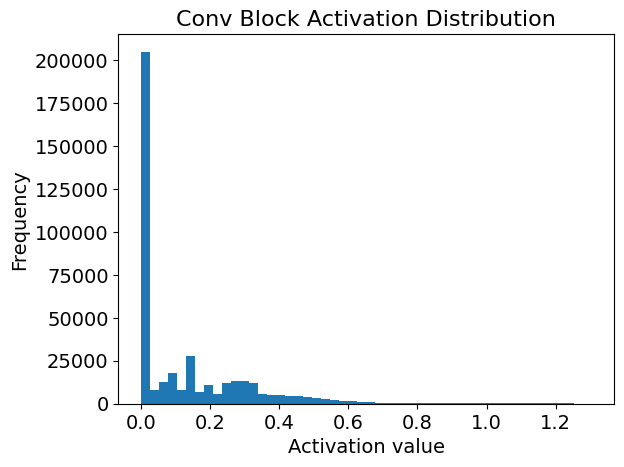

-------- Feature Map Activations ---------


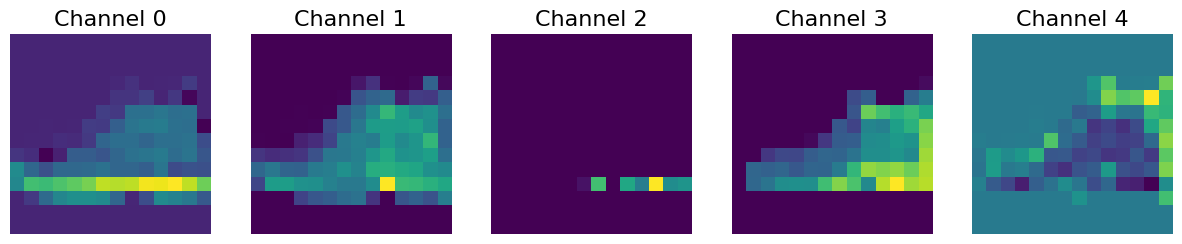

------- Per Channel Mean/STD ---------


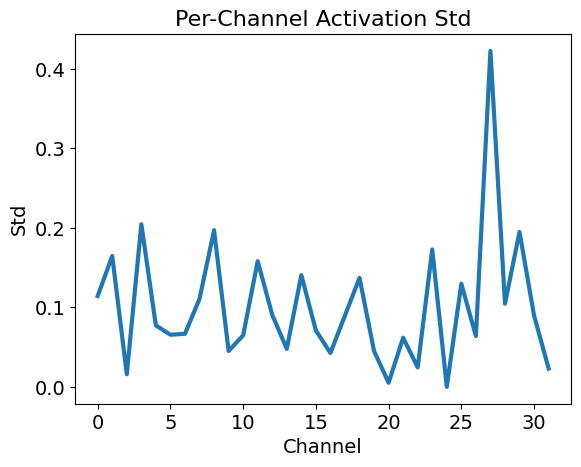

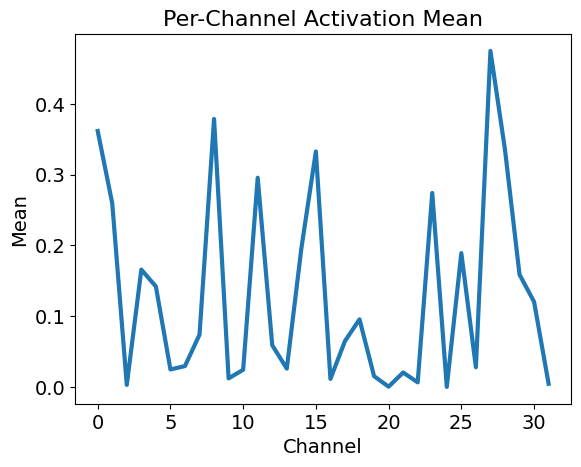

In [25]:
# Model: Inspect Layers

# get and plot activation statistics of layers 

# creating forward hooks to get activations so no need to modify the model's internals

activations = {}

def save_activation(name):
    """
    module: the layer
    input: input tensor(s)
    output: activation we want
    .detach() avoids interfering with autograd
    """
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook


model = SimpleCNNModularDebug()

# get stats of block
# block name: conv_block
model.conv_block.register_forward_hook(
    save_activation("conv_block")
)

# get stats of a layer within block
model.conv_block[0].register_forward_hook(
    save_activation("conv1_pre_activation")
)

# run forward pass
img_batch, _ = next(iter(dataloader))
_ = model(img_batch)

# activation stats stored here
activations["conv_block"]


# PLOT activation distributions of the block - Health
# Bell-shaped, centered -> good
# Sharp spike near 0 -> dead ReLUs
# Long tails -> exploding activations

print('----- Activation distribution of conv block -------')

import matplotlib.pyplot as plt

act = activations["conv_block"]

plt.hist(act.flatten().numpy(), bins=50)
plt.title("Conv Block Activation Distribution")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()


# PLOT individual feature maps - Interpretability
# Structured patterns → edges, textures, shapes
# Uniform dark maps → dead filters
# Extremely noisy maps → instability

print('-------- Feature Map Activations ---------')

# Take first image in batch, first few channels
feature_maps = act[0]  # shape: (C, H, W)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(feature_maps[i], cmap="viridis")
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")

plt.show()


# PLOT mean/std per channel
# A channel in a CNN is one feature map — the response of one convolutional filter across the entire spatial image. Each of those 16 channels is:
# Example: nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) => Each of those 16 channels is 1 learned filter, 1 feature map, 1 “pattern detector”

# Red flags:
# Many channels with std ≈ 0 -> dead filters
# A few channels with huge std -> exploding filters

print('------- Per Channel Mean/STD ---------')
channel_std = act.std(dim=(0, 2, 3))
channel_mean = act.mean(dim=(0, 2, 3))

plt.plot(channel_std.numpy())
plt.title("Per-Channel Activation Std")
plt.xlabel("Channel")
plt.ylabel("Std")
plt.show()

plt.plot(channel_mean.numpy())
plt.title("Per-Channel Activation Mean")
plt.xlabel("Channel")
plt.ylabel("Mean")
plt.show()


Total number of parameters in the model: 1248424
Number of Conv2d layers: 26
Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Layer features.0 has 14208 parameters
Layer features.1 has 0 parameters
Layer features.2 has 0 parameters
Layer features.3.squeeze has 1552 parameters
Layer features.3.squeeze_activation has 0 parameters
Layer features.3.expand1x1 has 1088 parameters
Layer features.3.expand1x1_activation has 0 parameters
Layer features.3.expand3x3 has 9280 parameters
Layer features.3.expand3x3_activation has 0 parameters
Layer features.4.squeeze has 2064 parameters
Layer features.4.squeeze_activation has 0 parameters
Layer features.4.expand1x1 has 1088 parameters
Layer features.4.expand1x1_activation has 0 parameters
Layer features.4.expand3x3 has 9280 parameters
Layer features.4.expand3x3_activation has 0 p

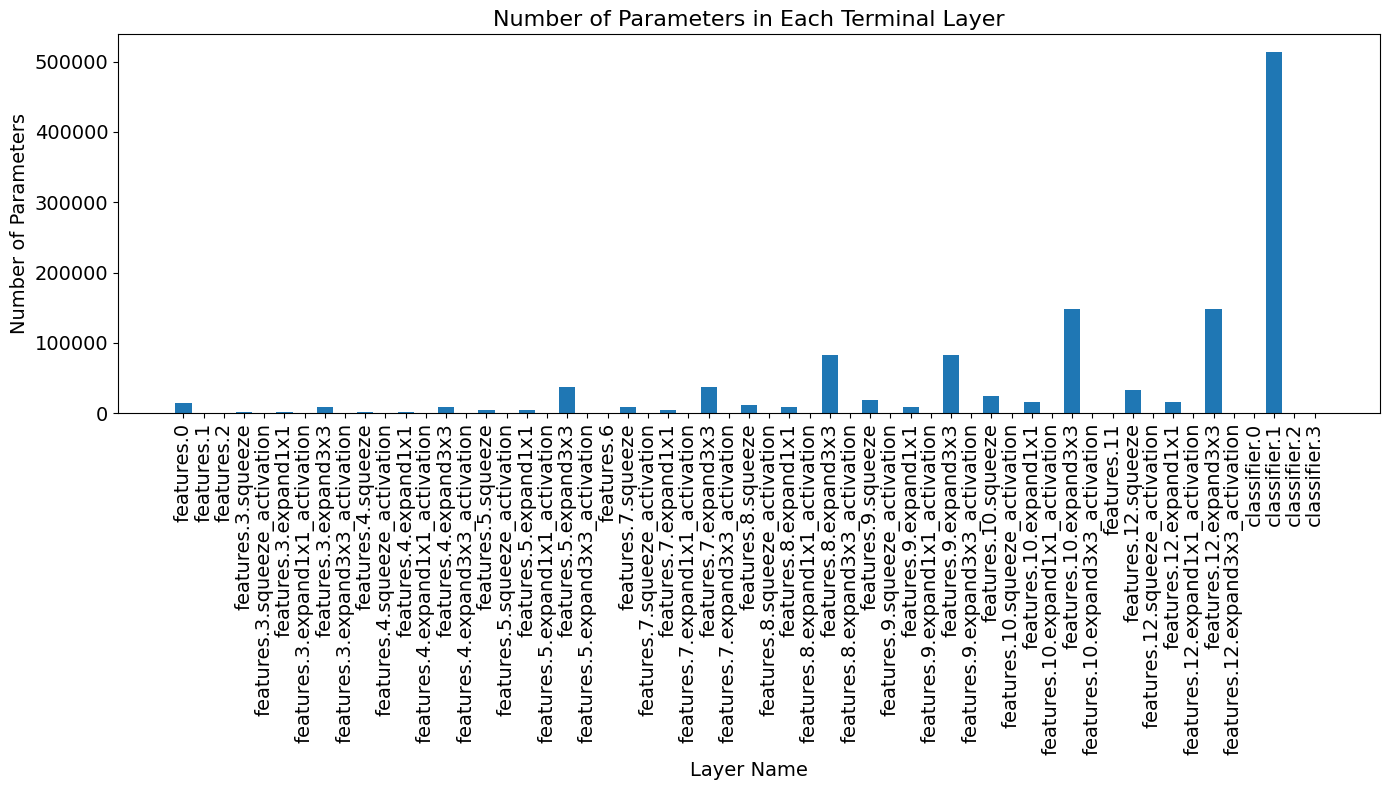

In [23]:
# Model Debugging: Pre-existing model

# Load SqueezeNet model
complex_model = SqueezeNet()

# print(complex_model)

# total number of parameters in the model
total_params = sum(p.numel() for p in complex_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

# count how many Conv2d layers are in the model
type_layer = nn.Conv2d
selected_layers = [layer for layer in complex_model.modules() if isinstance(layer, type_layer)]
print(f"Number of {type_layer.__name__} layers: {len(selected_layers)}")

# Iterate through the main blocks since printing entire model can be overwhelming
# for name, block in complex_model.named_children():
#     print(f"Block {name} has a total of {len(list(block.children()))} layers:")
    
#     # List all children layers in the block
#     for idx, layer in enumerate(block.children()):
#         # Check if the layer is terminal (no children) or not
#         if len(list(layer.children())) == 0:
#             print(f"\t {idx} - Layer {layer}")
#         # If the layer has children, it's a sub-block, then print only the number of children and its name
#         else:
#             layer_name = layer._get_name()  # More user-friendly name
#             print(f"\t {idx} - Sub-block {layer_name} with {len(list(layer.children()))} layers") 

# Zoom into a module or layer
first_fire_module = complex_model.features[3]
for idx, module in enumerate(first_fire_module.modules()):
    # Avoid printing the top-level module itself
    if idx > 0 :
        print(module)


# Inspect parameters of each terminal layer (layers without children)
# For each terminal layer, you will print its name and the total number of parameters it contains. 
# This helps to identify which layers contribute most to the model's parameter count and can be useful for model optimization, pruning, or understanding where the model's capacity lies.
counting_params = {}
for layer in complex_model.named_modules(): # For each terminal layer print its number of parameters
    n_children = len(list(layer[1].children()))
    if n_children == 0:  # Terminal layer
        layer_name = layer[0]
        n_parameters = sum(p.numel() for p in layer[1].parameters())
        counting_params[layer_name] = n_parameters
        print(f"Layer {layer_name} has {n_parameters} parameters")
plot_counting(counting_params) # Plotting the distribution of parameters per layer (helper function above)